# Stationrank

In [1]:
import os
import time
import json
import pygraphviz

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import datetime as dt
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [3]:
from networkx.drawing.nx_agraph import write_dot
from networkx.readwrite import json_graph
from shapely.geometry import Point, LineString
from shapely_geojson import dump, dumps, Feature, FeatureCollection
from tqdm.notebook import trange, tqdm
from scipy.linalg import norm
from scipy.linalg import eig
from matplotlib import cm
from ipywidgets import interact, interact_manual
from datetime import datetime, timedelta
from numpy import nan

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

[See the medium article 'SBB trains delay'](https://medium.com/@christopher.hogendijk/sbb-trains-delay-4b1e23f3bd15)

In [5]:
# Set month
month = 'September'

# Set index
imonth = '09'

In [6]:
# Clean data contains every "stop" for a month for all swiss railways
data = pd.read_pickle('data/istdaten/{}/data_clean_2019{}.pkl'.format(month, imonth))

In [301]:
data.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ABK,PRODUKT_ID,LINIEN_ID,LINIEN_TEXT,VERKEHRSMITTEL_TEXT,ZUSATZFAHRT_TF,FAELLT_AUS_TF,BPUIC,HALTESTELLEN_NAME,ANKUNFTSZEIT,AN_PROGNOSE,AN_PROGNOSE_STATUS,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,DURCHFAHRT_TF
218,01.09.2019,80:L7____:87875:000,SBB,Zug,87875,S5,S,False,False,8500090.0,Basel Bad Bf,01.09.2019 01:14,NaN,UNBEKANNT,NaN,NaN,PROGNOSE,False
350,01.09.2019,85:11:100:001,SBB,Zug,100,ICE,ICE,False,False,8500010.0,Basel SBB,NaN,NaN,PROGNOSE,01.09.2019 19:13,01.09.2019 19:13:55,REAL,False
351,01.09.2019,85:11:100:001,SBB,Zug,100,ICE,ICE,False,False,8500090.0,Basel Bad Bf,01.09.2019 19:19,01.09.2019 19:19:12,PROGNOSE,01.09.2019 19:23,01.09.2019 19:23:24,PROGNOSE,False
352,01.09.2019,85:11:1007:001,SBB,Zug,1007,IC4,IC,False,False,8503424.0,Schaffhausen,NaN,NaN,PROGNOSE,01.09.2019 05:47,01.09.2019 05:47:39,REAL,False
353,01.09.2019,85:11:1007:001,SBB,Zug,1007,IC4,IC,False,False,8503000.0,Zürich HB,01.09.2019 06:23,01.09.2019 06:22:52,REAL,NaN,NaN,PROGNOSE,False


In [305]:
# Collect features
features = []
# One feature per day
for day in data['BETRIEBSTAG'].unique():
    feature = data[(data['BETRIEBSTAG'] == day) & (data['BETREIBER_ABK'] == 'RhB')]
    # Reset index
    feature = feature.reset_index()
    feature = feature.drop(columns=['index'])
    features.append(feature)

## Load stations dataset (didok)

In [306]:
# Full didok data
didok = pd.read_csv('data/istdaten/{}/dienststellenfull.csv'.format(month), header=6, sep=";")

In [307]:
# Coordinates
didok = didok[['BPUIC', 'BEZEICHNUNG_OFFIZIELL', 'ABKUERZUNG', 'E_WGS84', 'N_WGS84']].drop_duplicates()
didok = didok[np.isfinite(didok['E_WGS84'])]
didok = didok.reset_index()
didok = didok.drop(columns=['index'])
didok.head(5)

,BPUIC,BEZEICHNUNG_OFFIZIELL,ABKUERZUNG,E_WGS84,N_WGS84
0,8504048,"Villariaz, Moulin Rouge",NaN,-14.801849,35.100356
1,8504049,"Villarepos, F. de Plan",NaN,-14.764508,35.330601
2,8519024,Basel SBB RB West,BRBW,-8.092301,55.603118
3,8519025,Basel SBB RB Ost,BRBO,-8.073794,55.600495
4,8557043,"Ennetbaden, Rütenen-Felmen",NaN,0.379039,47.265918


### Locations in project as BPUIC

In [316]:
# These are the specific stations of the project
locations = data.copy(deep=True)
locations = locations[locations['BETREIBER_ABK'] == 'RhB']
locations = locations[['HALTESTELLEN_NAME', 'BPUIC']].drop_duplicates()
locations.BPUIC = locations.BPUIC.astype(int)
locations = locations.reset_index()
locations = locations.drop(columns=['index'])
locations

,HALTESTELLEN_NAME,BPUIC
0,Davos Platz,8509073
1,Davos Dorf,8509072
2,Davos Wolfgang,8509071
3,Davos Laret,8509070
4,Klosters Platz,8509068
...,...,...
97,Le Prese (incrocio),8515161
98,Stablini,8516075
99,Schiers Schlangenboden,8509202
100,Sagliains Abzw Sasslatschtunne,8516945


### Georeferenced locations by BPUIC

In [317]:
geopos = []
abbreviation = []
for i, location in enumerate(locations.values):
    abb = didok.loc[didok['BPUIC']==location[1]].values[0][2]
    lon = didok.loc[didok['BPUIC']==location[1]].values[0][3]
    lat = didok.loc[didok['BPUIC']==location[1]].values[0][4]
    loc = [lon, lat]
    geopos.append(loc)
    abbreviation.append(abb)

In [318]:
locations['abbreviation'] = abbreviation
locations['geopos'] = geopos
locations.head(5)

,HALTESTELLEN_NAME,BPUIC,abbreviation,geopos
0,Davos Platz,8509073,DAV,"[9.82072515, 46.79146695]"
1,Davos Dorf,8509072,DAD,"[9.84211, 46.80972001]"
2,Davos Wolfgang,8509071,DAW,"[9.85454999, 46.831959999999995]"
3,Davos Laret,8509070,DALT,"[9.87191004, 46.84809364]"
4,Klosters Platz,8509068,KLO,"[9.88093585, 46.86921236]"


## Preprocessing

In [319]:
def discretize(x):
    if pd.isna(x):
        return None
    else:
        x = pd.to_datetime(x)
        return int((x.hour) * 60 + x.minute)

In [320]:
def span(x):
    if pd.isna(x['arrival']) ^ pd.isna(x['departure']):
        return 1
    elif pd.isna(x['arrival']) and pd.isna(x['departure']):
        return None
    else:
        diff = x['departure'] - x['arrival']
        if diff >= 0:
            return diff + 1
        else:
            return None

In [321]:
def timeline(lst, df):
    if pd.isna(df.loc[df.index[0]].arrival):
        start = int(df.loc[df.index[0]].departure)
    else:
        start = int(df.loc[df.index[0]].arrival)
    primer = {int(i): None for i in range(0, start)}
    main = {int(j + start): [lst[j]] for j in range(0, len(lst))}
    sequel = {int(k): None for k in range(start + len(lst), 60 * 24)}
    main.update(sequel)
    primer.update(main)
    return primer

In [322]:
# Collect diaries
diaries = []

for feature in tqdm(features):

    # Diary of routes
    diary = []
    for route in tqdm(
            feature.FAHRT_BEZEICHNER.unique(),
            desc=feature['BETRIEBSTAG'].unique()[0]):

        df = feature.loc[(feature.FAHRT_BEZEICHNER == route)]

        if len(df['HALTESTELLEN_NAME']) > 1:

            df['arrival'] = df['ANKUNFTSZEIT'].apply(discretize)
            df['departure'] = df['ABFAHRTSZEIT'].apply(discretize)

            # Sort routes by scheduled departure
            df = df.sort_values(
                by='ABFAHRTSZEIT', ascending=True, na_position='last')

            df['dwell'] = df[['arrival', 'departure']].apply(span, axis=1)
            df['running'] = df['arrival'].shift(-1) - df['departure'] - 1

            # Check for timetable errors
            if any(df['running'].values.ravel() < 0):
                continue
            if any(df['dwell'].values.ravel() < 0):
                continue

            df['next'] = df['HALTESTELLEN_NAME'].shift(-1)

            sentence = []
            for i, j, k, l in df[[
                    'HALTESTELLEN_NAME', 'next', 'dwell', 'running'
            ]].values:
                if pd.isna(j) or pd.isna(l):
                    sentence.append([i])
                elif pd.isna(k):
                    sentence.append([i])
                    break
                else:
                    sentence.append([i] * int(k))
                    sentence.append([i + '=>' + j] * int(l))

            flattened = [item for sublist in sentence for item in sublist]
            dic = timeline(flattened, df)
            if len(dic) > 1440:
                print(len(dic))
                break
            diary.append(dic)

    # Fill in the diaries
    diaries.append(pd.DataFrame(diary))

In [323]:
df

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ABK,PRODUKT_ID,LINIEN_ID,LINIEN_TEXT,VERKEHRSMITTEL_TEXT,ZUSATZFAHRT_TF,FAELLT_AUS_TF,BPUIC,...,AN_PROGNOSE_STATUS,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,DURCHFAHRT_TF,arrival,departure,dwell,running,next
4706,30.09.2019,85:72:976:000,RhB,Zug,976,PE,PE,False,False,8509369.0,...,PROGNOSE,30.09.2019 10:07,30.09.2019 10:08:16,PROGNOSE,False,NaN,607.0,1.0,32.0,Le Prese
4707,30.09.2019,85:72:976:000,RhB,Zug,976,PE,PE,False,False,8509364.0,...,REAL,30.09.2019 10:41,30.09.2019 10:43:07,REAL,False,640.0,641.0,2.0,5.0,Poschiavo
4708,30.09.2019,85:72:976:000,RhB,Zug,976,PE,PE,False,False,8509361.0,...,PROGNOSE,30.09.2019 10:48,30.09.2019 10:50:00,PROGNOSE,False,647.0,648.0,2.0,37.0,Alp Grüm
4709,30.09.2019,85:72:976:000,RhB,Zug,976,PE,PE,False,False,8509357.0,...,REAL,30.09.2019 11:42,30.09.2019 11:47:21,REAL,False,686.0,702.0,17.0,6.0,Ospizio Bernina
4710,30.09.2019,85:72:976:000,RhB,Zug,976,PE,PE,False,False,8509356.0,...,REAL,30.09.2019 11:52,30.09.2019 11:55:58,REAL,False,709.0,712.0,4.0,32.0,Pontresina
4711,30.09.2019,85:72:976:000,RhB,Zug,976,PE,PE,False,False,8509255.0,...,REAL,30.09.2019 12:27,30.09.2019 12:27:23,REAL,False,745.0,747.0,3.0,8.0,St. Moritz
4712,30.09.2019,85:72:976:000,RhB,Zug,976,PE,PE,False,False,8509253.0,...,REAL,NaN,NaN,PROGNOSE,False,756.0,NaN,1.0,NaN,NaN


In [324]:
print(flattened)

['Tirano', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Tirano=>Le Prese', 'Le Prese', 'Le Prese', 'Le Prese=>Poschiavo', 'Le Prese=>Poschiavo', 'Le Prese=>Poschiavo', 'Le Prese=>Poschiavo', 'Le Prese=>Poschiavo', 'Poschiavo', 'Poschiavo', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 'Poschiavo=>Alp Grüm', 

## Save the diaries for later use

In [325]:
# Export all diaries
for i, diary in enumerate(diaries):
    path = 'data/istdaten/{}/diaries/markov_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    diary.to_pickle(path)

## Load preprocessed data

In [327]:
Diaries = []
directory = 'data/istdaten/{}/diaries/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    d = pd.read_pickle(path)
    Diaries.append(d)

## Model construction

In [328]:
# Collect starting vectors
vectors = []
# Collect transition matrices
matrices = []
# Collect states
states = []

In [330]:
for diary in tqdm(Diaries):

    # Dictionary of stations
    dic = {'station': np.unique([x for x in diary.values.ravel() if x != None])}
    stations = pd.DataFrame(dic)
    states.append(stations)

    # Size of the matrix
    n = stations.shape[0]
    # Initialize a n*1 initial start vector
    t = (n)
    Distribution = pd.DataFrame(np.zeros(t))
    Initial = pd.DataFrame(np.zeros(t))
    Frequency = pd.DataFrame(np.zeros(t))
    # Initialize a n*n transition matrix
    s = (n, n)
    matrix = pd.DataFrame(np.zeros(s))

    for row in tqdm(diary.values):
        route = [x for x in row if x != None]
        stops = [item for sublist in route for item in sublist]
        
        # Initial vector
        pos_i = stations.loc[stations['station'] == stops[0]].index[0]
        Initial.iloc[pos_i] += 1
            
        # Transition matrix
        for i in range(len(stops) - 1):
            pos1 = stations.loc[stations['station'] == stops[i]].index[0]
            pos2 = stations.loc[stations['station'] == stops[i + 1]].index[0]  
            matrix.iloc[pos1, pos2] += 1
            
    # Fill in the vectors
    s = matrix.sum()
    Distribution['Station'] = dic['station']
    Distribution['Init'] = Initial.div(Initial.sum(axis=0), axis=1)
    Distribution['Freq'] = s/sum(s)
    Distribution = Distribution.drop(columns=[0])
    vectors.append(Distribution)

    # Fill in the matrices
    tran_matrix = matrix
    tran_matrix.columns = dic['station']
    tran_matrix['Index'] = dic['station']
    tran_matrix = tran_matrix.set_index('Index')
    matrices.append(tran_matrix)

## Save the model for later use

In [331]:
# Export all vectors
for i, vector in enumerate(vectors):
    path = 'data/istdaten/{}/vectors/markov_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    vector.to_pickle(path)

In [332]:
# Export all matrices
for i, matrix in enumerate(matrices):
    path = 'data/istdaten/{}/matrices/markov_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    matrix.to_pickle(path)

## Loading the model

In [333]:
# Set month
month = 'September'

# Set index
imonth = '09'

In [334]:
# Load starting vectors
Vs = []
directory = 'data/istdaten/{}/vectors/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    V = pd.read_pickle(path)
    Vs.append(V)

In [335]:
strings = []
for i in range(1, len(Vs)+1):
    string = '{:>02}.{}.2019'.format(i, imonth)
    strings.append(string)

In [570]:
# Load transition matrices
TMs = []
directory = 'data/istdaten/{}/matrices/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory,file)
    TM = pd.read_pickle(path)
    TMs.append(TM)

In [571]:
# Now convert to probabilities
singularities = []
for i, TM in tqdm(enumerate(TMs)):
    eps = .001
    count = 0
    for row in tqdm(TM.values):
        singularities.append([])
        s = sum(row)
        k = 0
        if sum(f > 0 for k, f in enumerate(row)) == 1 and count==k:
            print('Absorbing state at', Vs[i].iloc[count][1], i, '\n')
            row[:] = eps
            row[count] = 1.0
            row[:] = [f/sum(row) for f in row]
        if s == 0:
            singularity = Vs[i].iloc[count][1]
            singularities[i].append(singularity)
            print('Singularity at', singularity, i, '\n')
            row[:] = eps
            row[count] = 1.0
            _s = sum(row)
            row[:] = [f/_s for f in row]
        else:
            row[:] = [f/s for f in row]
        TM.values[count]=row
        count+=1

In [339]:
# Overview of singularities in the system by day of occurance
singular = pd.DataFrame(singularities).dropna(how ='all')
singular

""


In [340]:
# Matrix size
sizes = []
for TM in TMs:
    s = TM.values.ravel()
    size = round(sum(s)).astype(int)
    sizes.append(size)

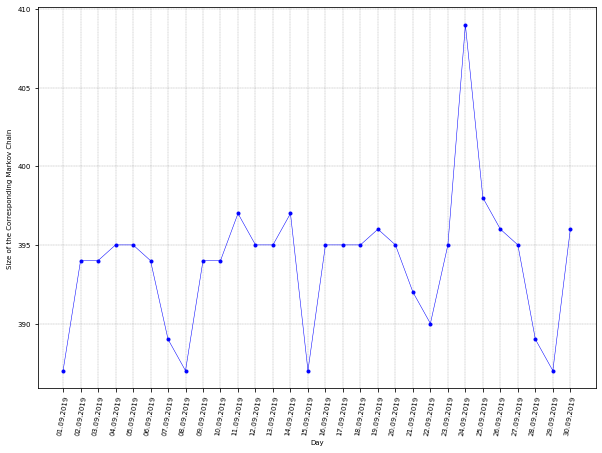

In [341]:
# Plot size
fig = plt.figure(figsize=(10, 7));
plt.plot(sizes, '.-b', linewidth=.51)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Size of the Corresponding Markov Chain')
plt.xlabel('Day')
xticks=[s for s in strings]
plt.xticks(range(len(sizes)), xticks, rotation=80, horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

## Analysis

In [342]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

### Using Power Iteration to calculate the steady state probabilities, Pi

In [344]:
Pi = []
Mixing_times = []

for TM in TMs:
    t, mixing_ = simulate_markov(TM)
    Pi.append(t)
    Mixing_times.append(mixing_)

Iterating 2474 times in 2.7219667434692383
Iterating 3693 times in 3.8559625148773193
Iterating 3899 times in 3.975956678390503
Iterating 3666 times in 3.7749621868133545
Iterating 3445 times in 3.628959894180298
Iterating 3749 times in 3.6029653549194336
Iterating 2442 times in 2.3429765701293945
Iterating 1931 times in 1.8410346508026123
Iterating 3756 times in 3.5969512462615967
Iterating 3861 times in 3.828958034515381
Iterating 4826 times in 5.242949962615967
Iterating 4033 times in 4.030957460403442
Iterating 3733 times in 3.8209657669067383
Iterating 1942 times in 1.9219825267791748
Iterating 2391 times in 2.5409815311431885
Iterating 3714 times in 4.585992336273193
Iterating 3732 times in 4.092982769012451
Iterating 3810 times in 4.094992160797119
Iterating 3672 times in 3.7579619884490967
Iterating 4017 times in 4.562956094741821
Iterating 2364 times in 2.6459710597991943
Iterating 1747 times in 1.9559845924377441
Iterating 3619 times in 4.290948390960693
Iterating 3262 times 

In [345]:
start = 0

### Average mixing time of Markov chains

In [347]:
# We run the power iteration for several times to see if there are some variations in the mixing time
n = 5
Mixing_times_n_times = np.zeros((n, len(TMs)))
for i in trange(n):
    for j in range(len(TMs)):
        _, mixing_ = simulate_markov(TMs[j], verbose='off')
        Mixing_times_n_times[i, j] = mixing_

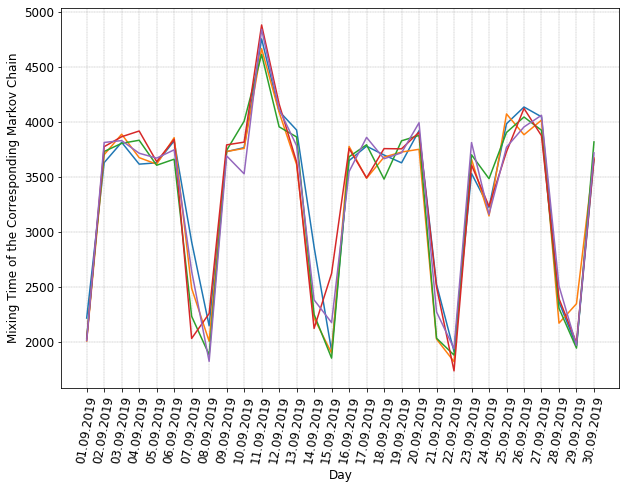

In [348]:
fig = plt.figure(figsize=(10, 7))
for mix in Mixing_times_n_times:
    plt.plot(mix[slice(start, None)])
font = {'size': 12}
plt.rc('font', **font)
plt.xlabel('Day')
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
xticks = [s for s in strings[slice(start, None)]]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks,
    rotation=80,
    horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

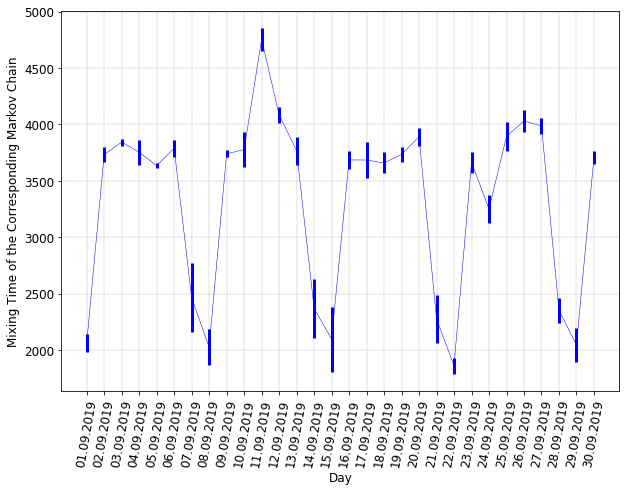

In [349]:
fig = plt.figure(figsize=(10, 7))
yerr = Mixing_times_n_times.std(axis=0)
plt.errorbar(
    range(len(TMs[slice(start, None)])),
    Mixing_times_n_times.mean(axis=0)[slice(start, None)],
    yerr=yerr[slice(start, None)],
    fmt='-',
    color='b',
    ecolor='b',
    linewidth=.5,
    elinewidth=3)
font = {'size': 12}
plt.rc('font', **font)

plt.xlabel('Day')
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
xticks = [s for s in strings[slice(start, None)]]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks,
    rotation=80,
    horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

In [350]:
def Kemeny_constant(MC):
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [352]:
Kemenys = []
pi_list = []

for TM in TMs:
    A = TM.values
    K, pi = Kemeny_constant(A)
    print(K, np.sum(pi))
    Kemenys.append(K)
    pi_list.append(pi)

5392.968209489744 1.0
5563.839115060708 1.0000000000000002
5586.065822041111 1.0
5574.992500127337 1.0
5537.111195951577 0.9999999999999999
5498.582964531519 1.0
5435.822709166736 1.0
5391.79598208791 1.0
5569.701082395545 1.0
5569.701082395545 1.0
5842.657589294192 1.0
5498.243606038333 1.0
5505.400435690264 1.0
5759.5507546467325 0.9999999999999999
5387.631028917956 1.0000000000000002
5590.566644413055 1.0
5590.575926973275 1.0
5590.566644413055 1.0
5557.870103584219 1.0
5530.4563014273435 1.0
5436.689833899798 1.0
5556.270007724647 1.0
5583.291253268959 1.0
5966.252118274466 1.0
5598.927243605554 1.0
5560.7783059033045 0.9999999999999999
5528.097001027327 0.9999999999999999
5435.822709166736 1.0
5470.503841312291 0.9999999999999998
5563.23788778243 1.0


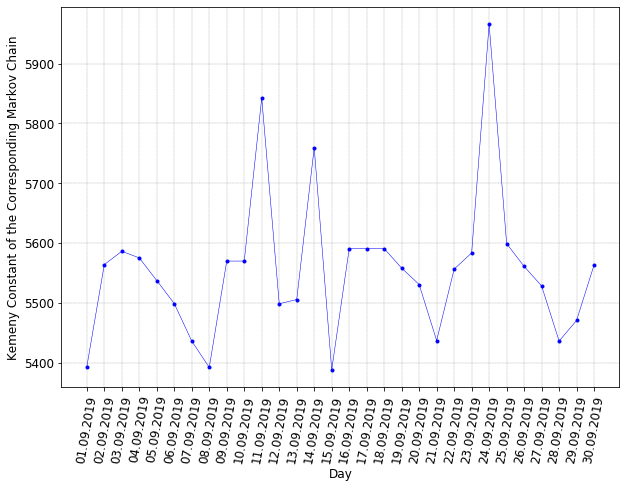

In [353]:
fig = plt.figure(figsize=(10, 7))
plt.plot(Kemenys[slice(start, None)], '.-b', linewidth=.51)

font = {'size': 12}
plt.rc('font', **font)

plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Kemeny Constant of the Corresponding Markov Chain')
xticks = [s for s in strings]
plt.xticks(
    range(len(TMs[slice(start, None)])),
    xticks[slice(start, None)],
    rotation=80,
    horizontalalignment='center')

plt.show()
plt.close()

In [815]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector
    Steady_dist['Pi'] = pi_list[i]
    Steady_dist['Freq'] = vector.Freq.values    
    Steady_dist['Init'] = vector.Init.values
    Steady_dist['Date'] = str(datetime(year=2019, month=9, day=int(i + 1)))
    Steady_dist['Flag'] = ~Steady_dist['Station'].str.contains('=>')
    Steady_dist = Steady_dist[['Station', 'Pi', 'Freq', 'Init', 'Date', 'Flag']]
    #Steady_dist = Steady_dist[~Steady_dist['Station'].str.contains('=>')]
    steady_states.append(Steady_dist)

## Results

In [816]:
# Compute pagerank
stationranks = []

for steady in steady_states:
    stationrank = steady.sort_values(['Pi'], ascending=False)
    stationrank = stationrank.reset_index()
    stationrank = stationrank.drop(columns=['index'])
    stationranks.append(stationrank)

In [817]:
# Google it!
@interact
def rank(day=(start, len(steady_states) - 1)):
    return stationranks[day].head(20)

interactive(children=(IntSlider(value=14, description='day', max=29), Output()), _dom_classes=('widget-interac…

In [819]:
# Google it!
@interact
def scatter(day=(start, len(steady_states) - 1)):
    cmap = cm.get_cmap('Spectral_r')
    fig, ax = plt.subplots(figsize=(5.5,5))
    stationranks[day].plot.scatter(x='Freq', y='Pi', s=5, c='Init', cmap=cmap, ax=ax) 

interactive(children=(IntSlider(value=14, description='day', max=29), Output()), _dom_classes=('widget-interac…

In [576]:
selected_states = []
for state in steady_states:
    state = state[~state['Station'].str.contains('=>')]
    state.set_index('Station', inplace=True)
    selected_states.append(state)

In [577]:
# Merge stations over whole month
merge = pd.concat(selected_states, axis=1, join='inner')
merge

,Pi,Freq,Init,Date,Flag,Pi,Freq,Init,Date,Flag,...,Pi,Freq,Init,Date,Flag,Pi,Freq,Init,Date,Flag
Station,,,,,,,,,,,,,,,,,,,,,
Alp Grüm,0.006577,0.005651,0.00000,2019-09-01 00:00:00,True,0.008914,0.005606,0.000000,2019-09-02 00:00:00,True,...,0.006356,0.005665,0.000000,2019-09-29 00:00:00,True,0.008990,0.005580,0.000000,2019-09-30 00:00:00,True
Alvaneu,0.000168,0.000195,0.00000,2019-09-01 00:00:00,True,0.000194,0.000217,0.000000,2019-09-02 00:00:00,True,...,0.000167,0.000195,0.000000,2019-09-29 00:00:00,True,0.000200,0.000216,0.000000,2019-09-30 00:00:00,True
Arosa,0.000273,0.000663,0.04607,2019-09-01 00:00:00,True,0.000218,0.000615,0.043147,2019-09-02 00:00:00,True,...,0.000391,0.000664,0.043716,2019-09-29 00:00:00,True,0.000226,0.000612,0.043147,2019-09-30 00:00:00,True
Bergün/Bravuogn,0.001871,0.001832,0.00000,2019-09-01 00:00:00,True,0.001880,0.001736,0.000000,2019-09-02 00:00:00,True,...,0.001868,0.001836,0.000000,2019-09-29 00:00:00,True,0.001916,0.001728,0.000000,2019-09-30 00:00:00,True
Bernina Diavolezza,0.002261,0.001910,0.00000,2019-09-01 00:00:00,True,0.002885,0.001953,0.000000,2019-09-02 00:00:00,True,...,0.002176,0.001915,0.000000,2019-09-29 00:00:00,True,0.002906,0.001944,0.000000,2019-09-30 00:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Versam-Safien,0.000396,0.002416,0.00000,2019-09-01 00:00:00,True,0.000224,0.001628,0.000000,2019-09-02 00:00:00,True,...,0.000395,0.002422,0.000000,2019-09-29 00:00:00,True,0.000232,0.001620,0.000000,2019-09-30 00:00:00,True
Waltensburg/Vuorz,0.000095,0.000974,0.00000,2019-09-01 00:00:00,True,0.000082,0.000977,0.000000,2019-09-02 00:00:00,True,...,0.000095,0.000977,0.000000,2019-09-29 00:00:00,True,0.000088,0.001008,0.000000,2019-09-30 00:00:00,True
Zernez,0.007866,0.005417,0.00000,2019-09-01 00:00:00,True,0.006865,0.005498,0.002538,2019-09-02 00:00:00,True,...,0.007878,0.005431,0.000000,2019-09-29 00:00:00,True,0.006751,0.005472,0.002538,2019-09-30 00:00:00,True


In [578]:
indices = merge.index.values

## Share in Trains per Day (red) compared to structural power (blue) over time

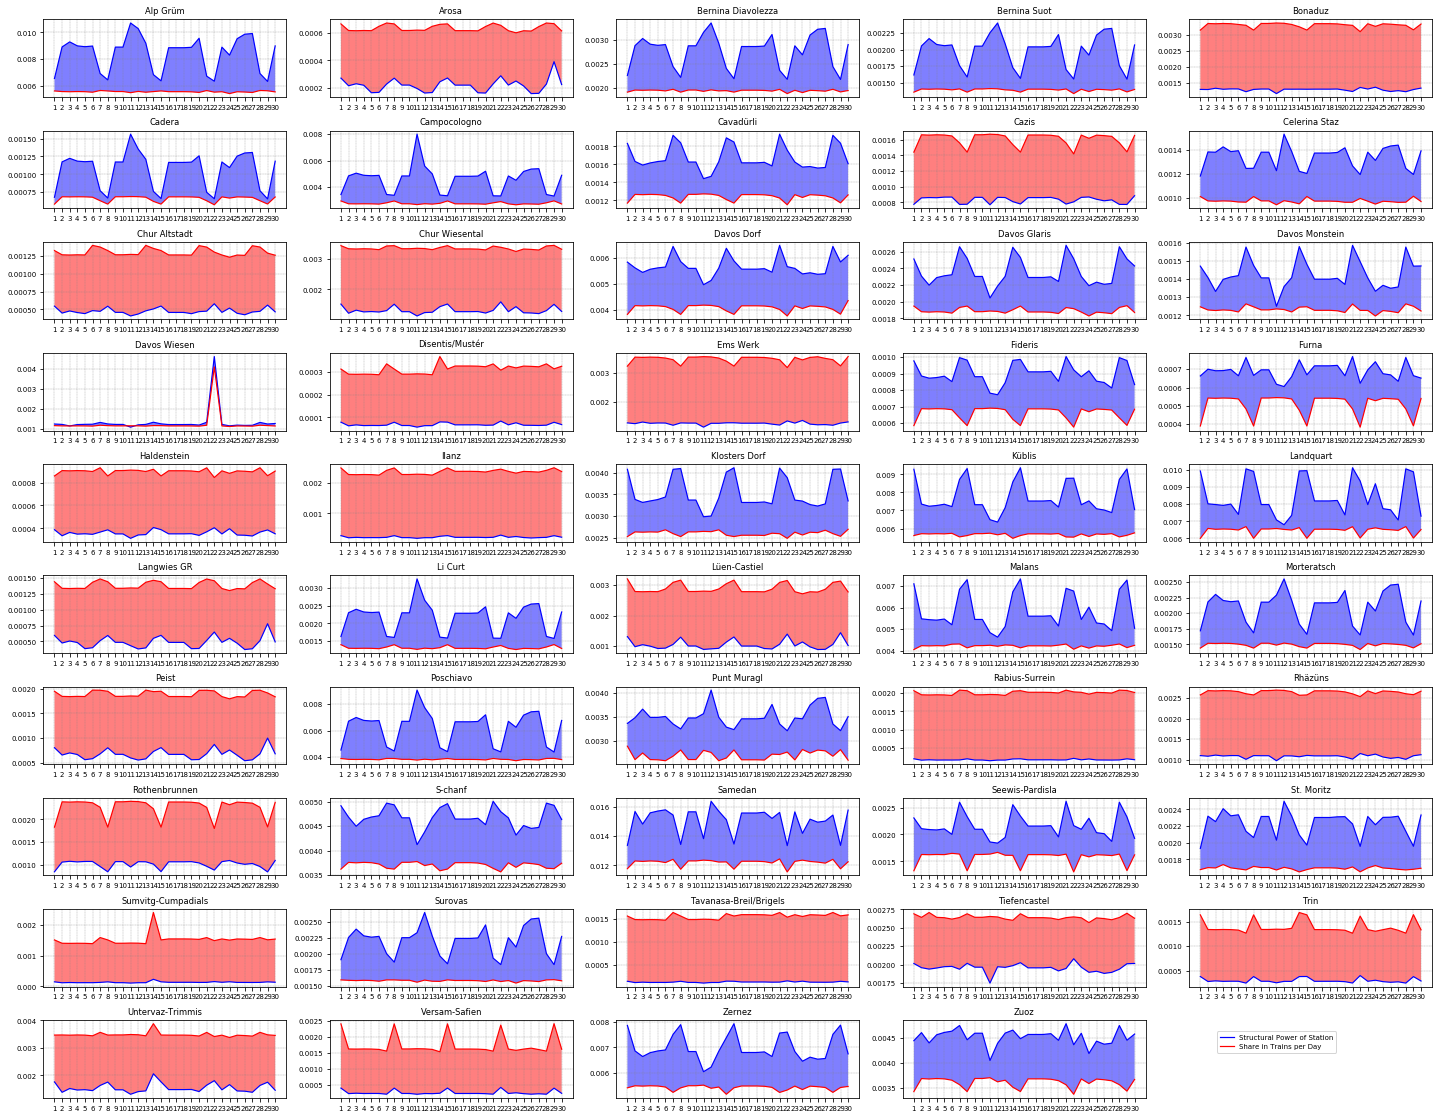

In [579]:
fig = plt.figure(figsize=(20, 20))
font = {'size': 7}
plt.rc('font', **font)

for j, i in enumerate(trange(0, len(indices), 2), 1):

    yPi = merge.loc[indices[i]][0::5].values
    yFreq = merge.loc[indices[i]][1::5].values

    plt.subplot(13, 5, j)
    plt.title(indices[i])

    plt.plot(
        range(len(steady_states)),
        yPi,
        '-b',
        linewidth=1.2,
        label='Structural Power of Station')
    plt.plot(
        range(len(steady_states)),
        yFreq,
        '-r',
        linewidth=1.2,
        label='Share in Trains per Day')
    
    y1 = yPi.astype(float)
    y2 = yFreq.astype(float)
    x = range(len(steady_states))

    plt.fill_between(
        x, y1, y2, where=y2 >= y1, facecolor='red', alpha=.5, interpolate=True)
    plt.fill_between(
        x, y1, y2, where=y2 <= y1, facecolor='blue', alpha=.5, interpolate=True)

    label = range(1, len(steady_states) + 1)
    plt.xticks(range(len(steady_states)), label)
    plt.tight_layout()
    plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.legend(bbox_to_anchor=(1.8, 0.9))
plt.show()
plt.close()

## Sensitivity analysis of Markov chains

In [869]:
# Sensitivity analysis on a single node
def change_node(M, i, percent=-99):
    eps = .001
    MC = M.T.copy()
        
    MC[i, :] = MC[i, :] * (1 + percent * .01)
    MC[:, i] = MC[:, i] * (1 + percent * .01)
    MC[i, i] = MC[i, i] / (1 + percent * .01)

    for i in range(MC.shape[0]):
        s = sum(MC[i])
        
        if s == 0:
            MC[i] = eps
            MC[i, i] = 1.
            s = sum(MC[i])
            MC[i] = np.divide(MC[i], s)

        else:
            MC[i] = np.divide(MC[i], s)

    return MC

In [909]:
percent = -99
DFs = []
#selected_stations = ['Aarau', 'Bern', 'Chur', 'Landquart', 'Olten', 'Zürich HB']
selected_stations = ['Arosa']

#for d in trange(len(TMs)):
TM = TMs[0].copy(deep=True)
names_perturbed = []
indices_perturbated = []
Kemenys_perturbed = []
Kemenys_diff = []
Pi_perturbed = []
Pi_diff = []
e0 = time.time()
K_normal, pi_normal = Kemeny_constant(TM)

for station in selected_stations:
    ind = np.where(TM.index == station)[0][0]
    Perturbed_TM = change_node(TM.values, ind, percent)

    K, pi = Kemeny_constant(Perturbed_TM)
    #_, mixing_ = simulate_markov(Perturbed_TM, verbose='off')

    if np.any(pi < 0):
        flag = True
        print('something went wrong!')            
    else:
        flag = False
        indices_perturbated.append(ind)
        names_perturbed.append(station)
        Kemenys_perturbed.append(K)
        Kemenys_diff.append(100 * (K - K_normal) / K_normal)
        Pi_perturbed.append(pi)
        Pi_diff.append(np.asarray(100 * (pi - pi_normal) / pi_normal))

print("Sensitivity of TM {}, in {} second".format(
    datetime(year=2019, month=9, day=int(d + 1)),
    time.time() - e0))
print(names_perturbed)
print(Kemenys_diff, '\n')
if not flag:
    DF = pd.DataFrame(index=names_perturbed, data=np.asarray(Pi_diff), columns=TM.index)
    DFs.append(DF)

Sensitivity of TM 2019-09-30 00:00:00, in 0.23735690116882324 second
['Arosa']
[154.90523509626078] 



In [910]:
DFs[0]

Index,Alp Grüm,Alp Grüm=>Cavaglia,Alp Grüm=>Ospizio Bernina,Alp Grüm=>Pontresina,Alp Grüm=>Poschiavo,Alvaneu,Alvaneu=>Filisur,Alvaneu=>Surava,Arosa,Arosa=>Litzirüti,...,Zernez=>Cinuos-chel-Brail,Zernez=>S-chanf,Zernez=>Susch,Zizers,Zizers=>Igis,Zizers=>Untervaz-Trimmis,Zuoz,Zuoz=>Bever,Zuoz=>Madulain,Zuoz=>S-chanf
Arosa,-80.42636,-83.094832,-60.730258,544.587308,-76.801978,238.729274,30.443561,461.345398,-98.34043,-83.036294,...,-89.693121,-70.348523,-80.381629,40.206515,41.911894,158.646917,-51.174929,49.50407,61.288858,-27.339671


In [911]:
print(selected_stations[0], indices_perturbated[0])

Arosa 8


In [912]:
TM.iloc[indices_perturbated[0]]

Alp Grüm                     0.0
Alp Grüm=>Cavaglia           0.0
Alp Grüm=>Ospizio Bernina    0.0
Alp Grüm=>Pontresina         0.0
Alp Grüm=>Poschiavo          0.0
                            ... 
Zizers=>Untervaz-Trimmis     0.0
Zuoz                         0.0
Zuoz=>Bever                  0.0
Zuoz=>Madulain               0.0
Zuoz=>S-chanf                0.0
Name: Arosa, Length: 387, dtype: float64

In [913]:
Pi_diff[0][indices_perturbated[0]]

-98.34042986029984

In [914]:
Pi_diff[0][np.where(TMs[0].index == 'St. Moritz')[0][0]]

-23.620276540787795

## Network Visualization

In [ ]:
def station_graph(index):
    TM = TMs[index]
    timestamp = pd.DataFrame({'year': [2019], 'month': [9], 'day': [index + 1]})
    # Construct the graph
    G = nx.MultiDiGraph()
    for i, origin_state in enumerate(list(TM.index)):
        for j, destination_state in enumerate(list(TM.columns)):
            rate = TM.iloc[i, j]
            if rate > 0:
                G.add_edge(
                    origin_state,
                    destination_state,
                    weight=rate,
                    Date=str(pd.to_datetime(timestamp)[0]))
    df = DFs[index].T.rename(
        columns={
            'Aarau': 'AA',
            'Bern': 'BE',
            'Chur': 'CH',
            'Landquart': 'LA',
            'Olten': 'OL',
            'Zürich HB': 'ZH'
        })
    attrs = pd.concat([df, steady_states[index]], axis=1).T.to_dict()
    #attrs = steady_states[index].T.to_dict()
    nx.set_node_attributes(G, attrs)
    return G

### Prepare for kepler.gl

In [ ]:
node_features = []
edge_features = []

In [ ]:
for index in trange(len(steady_states)-26):
    G = station_graph(index)
    graph = json_graph.node_link_data(G)
    for props in graph['nodes']:
        pos = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'id']].geopos.values[0]
        feature = Feature(Point(tuple(pos)), properties=props)
        node_features.append(feature)
    for props in graph['links']:
        source = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'source']].geopos.values[0]
        target = locations.loc[locations['HALTESTELLEN_NAME'] == props[
            'target']].geopos.values[0]
        feature = Feature(
            LineString([Point(tuple(source)),
                        Point(tuple(target))]), properties=props)
        edge_features.append(feature)

In [ ]:
# Gather all features
graph_features = node_features + edge_features
feature_collection = FeatureCollection(graph_features)

In [ ]:
# Write to file as geojson
with open('data/istdaten/September/map.geojson', 'w') as outfile:
     dump(feature_collection, outfile, indent=2, ensure_ascii=False)
outfile.close()

[See online app here](https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/s/p10n10r99h0lizi/keplergl_snm01s5.json)

### Interactive Plots

In [ ]:
def plot_station_graph(index, size, geo=True, labels=False, target='ZH'):
    G = station_graph(index)
    bond = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    # Get pagerank metrics on each node
    pi = np.array(list(nx.get_node_attributes(G, 'Pi').values()))
    pi_ = np.array(list(nx.get_node_attributes(G, target).values()))

    # Layout
    pos = nx.spring_layout(G, seed=1)
    if not geo:
        plt.figure(figsize=(50, 50))
        nx.draw(
            G,
            pos=pos,
            edge_color=bond,
            node_color=pi_,
            cmap=plt.cm.Accent,
            edge_cmap=plt.cm.Blues_r,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, size),
            width=bond * 10,
            alpha=0.7)

    elif geo:
        # Overwrite random graph positions with the georeferenced locations
        geopos = pos.copy()
        for key, value in geopos.items():
            geopos[key] = np.array(locations.loc[locations['HALTESTELLEN_NAME']
                                                 == key].geopos.values[0])
        plt.figure(figsize=(50, 35))
        nx.draw(
            G,
            pos=geopos,
            edge_color=bond,
            node_color=pi_,
            cmap=plt.cm.viridis,
            edge_cmap=plt.cm.Blues_r,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, size),
            width=bond * 10,
            alpha=0.7)

    plt.show()

In [ ]:
interact(
    plot_station_graph,
    index=(0, 29),
    size=(4.5, 6.0),
    geo={True, False},
    labels={True, False},
    target={'AA','BE','CH','LA','OL','ZH'});

## Export the Graph

In [ ]:
# Write to file for further visualization

index=0
write_dot(station_graph(index), 'data/mc.dot')

[See visualization here](https://nbviewer.jupyter.org/github/GAnagno/Social-Web/blob/master/data/markov/01092019.png)